# Are the TRAPPIST-1 flares associated with bright regions?

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

import sys
sys.path.insert(0, '../')

Remove outlier fluxes, mask out flares, median filter the light curve (5 cadence kernel)

In [2]:
from astropy.io import fits

f = fits.getdata('../libra/data/trappist_everest_luger.fits')
k2_time, k2_flux = f['TIME'][:-100] + 2454833, f['FLUX'][:-100], 

# Mask out strange fluxes
k2_flux /= np.median(k2_flux)

k2_time = k2_time[~np.isnan(k2_flux) & (k2_flux > 0.8) & (k2_flux < 1.2)]
k2_flux = k2_flux[~np.isnan(k2_flux) & (k2_flux > 0.8) & (k2_flux < 1.2)] 

p = np.polyfit((k2_time - k2_time.mean()), k2_flux, 5)
k2_flux -= np.polyval(p, k2_time - k2_time.mean())

k2_time_flares = k2_time.copy()
k2_flux_flares = k2_flux.copy()

flare_times = np.loadtxt('flare_times.txt')
during_flares = np.any(np.abs(k2_time - flare_times[:, np.newaxis]) < 0.1, axis=0)

k2_time = k2_time[~during_flares]
k2_flux = k2_flux[~during_flares]

from scipy.signal import medfilt

k2_flux = medfilt(k2_flux, (5,))

k2_error = np.ones_like(k2_flux) * np.std(k2_flux)/3

Model the K2 light curve with a SHO kernel from `celerite`:

In [3]:
import celerite
from celerite import terms

kernel = terms.SHOTerm(-11.60656534,  -2.43609442,   2.52251431)

gp = celerite.GP(kernel, mean=np.mean(k2_flux))
gp.compute(k2_time, k2_error)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(k2_flux)))

Initial log likelihood: 18679.720011517435


In [4]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(k2_flux, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -18813.070166375954
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.01346052, -0.0170985 , -0.01491571])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 72
      nit: 12
   status: 0
  success: True
        x: array([-11.84713947,  -1.16351291,   1.43397978])


In [5]:
x = np.arange(k2_time.min(), k2_time.max(), 1/24)
pred_mean, pred_var = gp.predict(k2_flux, x, return_var=True)

gp_model = gp.predict(k2_flux, k2_time)

pred_std = np.sqrt(pred_var)

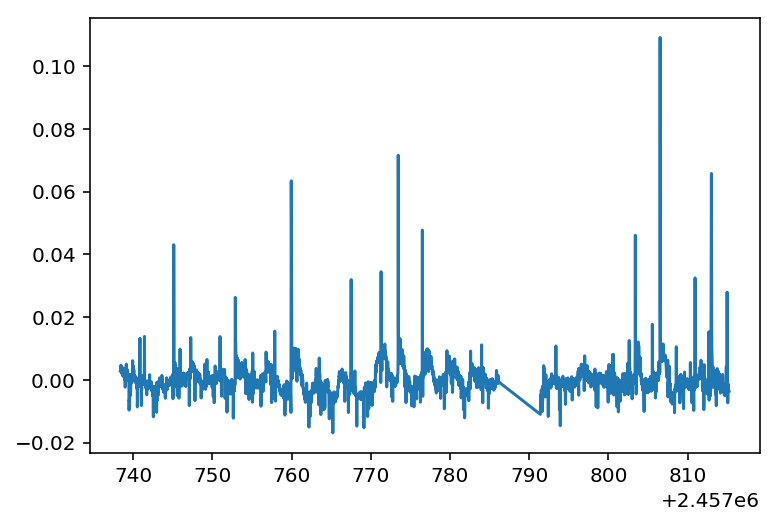

In [6]:
plt.plot(k2_time_flares, k2_flux_flares)

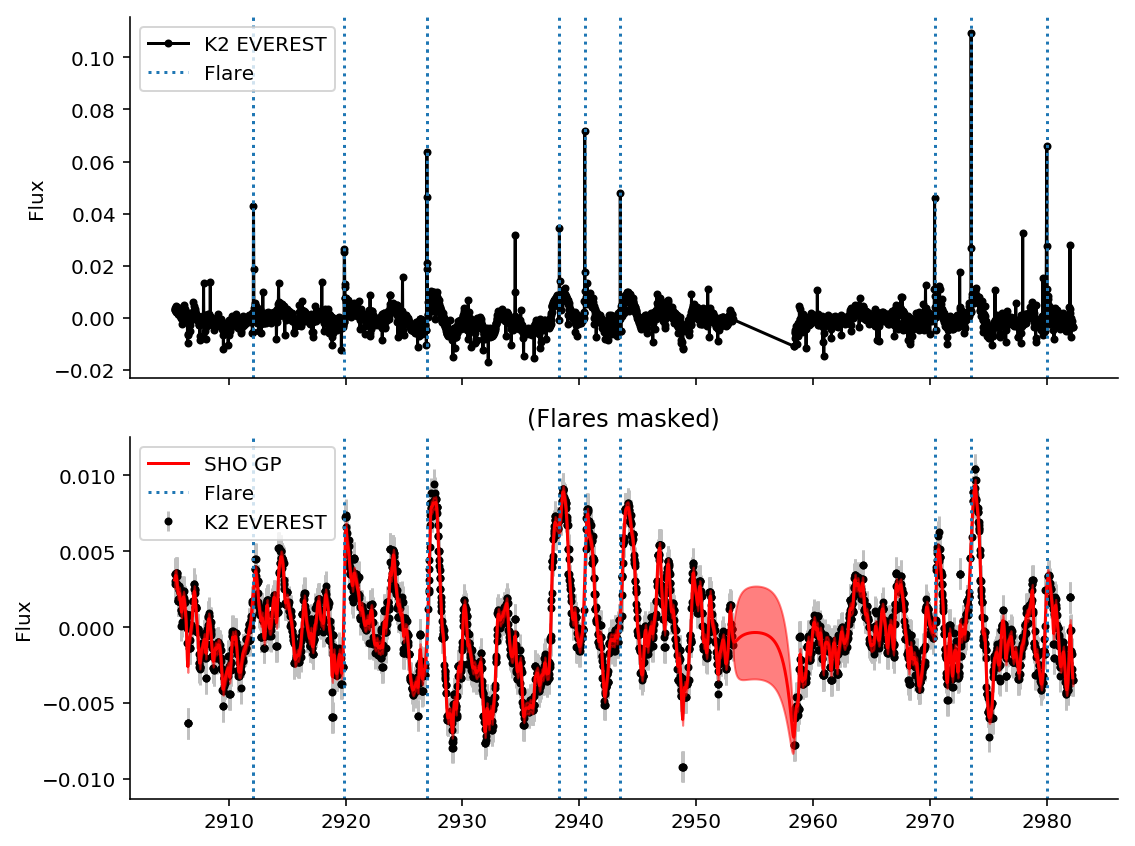

In [77]:
# fig, ax = plt.subplots(3, 1, figsize=(8, 10), sharex=True)#figsize=(14, 6))

# bjd_offset = 2454833

# ax[0].plot(k2_time_flares - bjd_offset, k2_flux_flares, '.-k', label='K2 EVEREST')

# ax[1].errorbar(k2_time - bjd_offset, k2_flux, k2_error, fmt='.', color='k', ecolor='silver', label='K2 EVEREST', zorder=-10)

# ax[1].set_title('(Flares masked)')
# ax[1].plot(x - bjd_offset, pred_mean, 'r', label='SHO GP')
# ax[1].fill_between(x - bjd_offset, pred_mean + pred_std, pred_mean - pred_std, color='r', alpha=0.5,
#                    edgecolor="none")

# ax[2].errorbar(k2_time - bjd_offset, k2_flux - gp_model[0], k2_error, fmt='.', color='k', ecolor='silver',)
# ax[1].set(ylabel='Flux')
# ax[2].set(xlabel='BJD - 2454833 [d]', ylabel='Residuals')
# ax[0].set(ylabel='Flux')

# for i, t in enumerate(flare_times):
#     label = None
#     if i == 0:
#         label = 'Flare'
#     for axis in ax:
#         axis.axvline(t - bjd_offset, ls=':', label=label)

# for axis in ax:
#     for loc in ['right', 'top']:
#         axis.spines[loc].set_visible(False)

# ax[1].legend()
# ax[0].legend()

# fig.tight_layout()
# fig.savefig('flare_gp_model.pdf', bbox_inches='tight')

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)#figsize=(14, 6))

bjd_offset = 2454833

ax[0].plot(k2_time_flares - bjd_offset, k2_flux_flares, '.-k', label='K2 EVEREST')

ax[1].errorbar(k2_time - bjd_offset, k2_flux, k2_error, fmt='.', color='k', ecolor='silver', label='K2 EVEREST', zorder=-10)

ax[1].set_title('(Flares masked)')
ax[1].plot(x - bjd_offset, pred_mean, 'r', label='SHO GP')
ax[1].fill_between(x - bjd_offset, pred_mean + pred_std, pred_mean - pred_std, color='r', alpha=0.5,
                   edgecolor="none")
ax[1].set(ylabel='Flux')
ax[0].set(ylabel='Flux')

for i, t in enumerate(flare_times):
    label = None
    if i == 0:
        label = 'Flare'
    for axis in ax:
        axis.axvline(t - bjd_offset, ls=':', label=label)

for axis in ax:
    for loc in ['right', 'top']:
        axis.spines[loc].set_visible(False)

ax[1].legend()
ax[0].legend()

fig.tight_layout()
fig.savefig('flare_gp_model.pdf', bbox_inches='tight')

In [8]:
gp_model_flares = gp.predict(k2_flux, flare_times)[0]

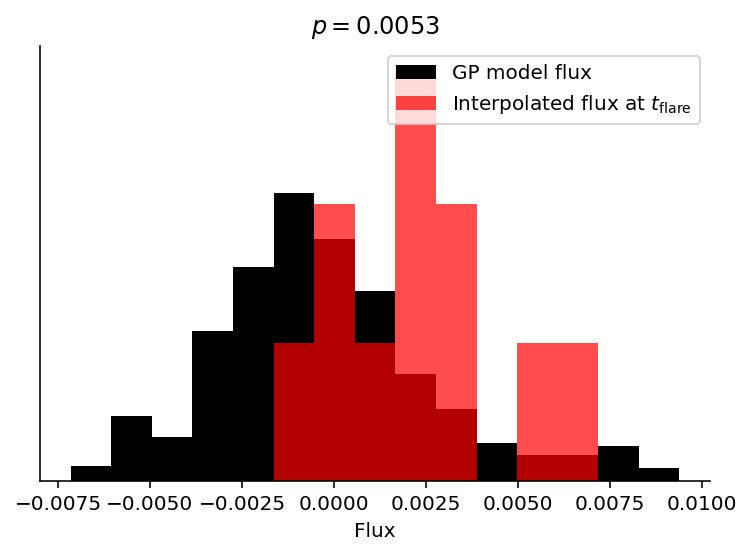

In [74]:
n, bins, _ = plt.hist(gp_model[0], bins=15, normed=True, histtype='stepfilled', color='k', label='GP model flux')
# for i, gpf in enumerate(gp_model_flares):
#     if i == 0: 
#         plt.axvline(gpf, color='r', label='Flux at $t_\mathrm{flare}$')
#     else: 
#         plt.axvline(gpf, color='r')
plt.hist(gp_model_flares, normed=True, bins=bins, color='r', histtype='stepfilled', 
         alpha=0.7, label='Interpolated flux at $t_\mathrm{flare}$')
plt.legend()
plt.xlabel('Flux')
plt.yticks([])

from scipy.stats import ttest_ind
pvalue = ttest_ind(gp_model[0], gp_model_flares).pvalue

plt.title('$p={0:.4f}$'.format(pvalue))

ax = plt.gca()
for loc in ['right', 'top']:
    ax.spines[loc].set_visible(False)
plt.savefig('flare_flux_distribution.pdf', bbox_inches='tight')

Is the distribution of fluxes at the times of flares have a statistically different mean than the rest of the residuals?

In [10]:
pvalue


0.0053000713780630392

$p \sim 10^{-3}$ is *yes*, the flares occur at times of higher flux. 

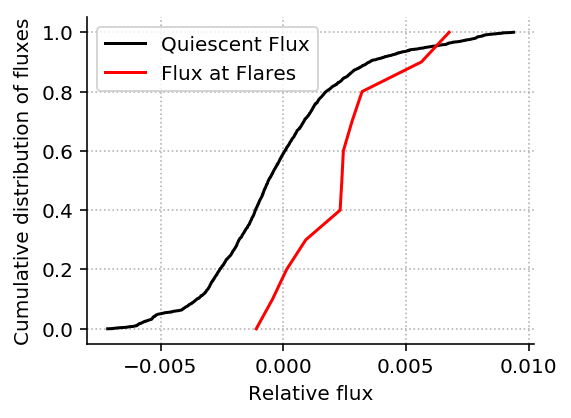

In [11]:
gp_fluxes_sort = np.sort(gp_model[0])
x1 = np.arange(len(gp_fluxes_sort))/(len(gp_fluxes_sort) - 1)

flare_times_sort = np.sort(gp_model_flares)
x2 = np.arange(len(flare_times_sort))/(len(flare_times_sort)-1)

fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(gp_fluxes_sort, x1, label='Quiescent Flux', color='k')
ax.plot(flare_times_sort, x2, label='Flux at Flares', color='r')
ax.set_xlabel('Relative flux')
ax.set_ylabel('Cumulative distribution of fluxes')
ax.grid(ls=':')
ax.legend()
for i in ['right', 'top']:
    ax.spines[i].set_visible(False)
fig.savefig('flare_flux_distribution.pdf', bbox_inches='tight')

In [36]:
3.3 / (0.5/24)

158.4

In [50]:
flare_times

array([ 2457745.11      ,  2457745.11949007,  2457752.88371535,
        2457759.93273949,  2457759.9736034 ,  2457771.29281912,
        2457773.45857741,  2457776.50289287,  2457803.39079186,
        2457806.5168182 ,  2457813.01406197])

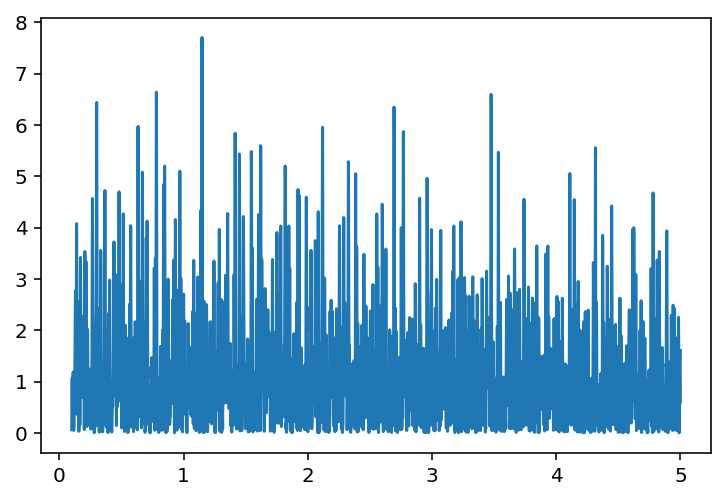

In [57]:
import rayleigh
import numpy as np

periods = np.linspace(0.1, 5, 5000)
ps = rayleigh.RayleighPowerSpectrum(flare_times, minper=0.1, maxper=5, nper=5000)

plt.plot(periods, list(ps))

In [81]:
pred_k2, pred_var = gp.predict(k2_flux, k2_time_flares, return_var=True)

In [113]:
from scipy.integrate import simps

flare_times = np.loadtxt('flare_times.txt')

integrated_flare_fluxes = []
quiescent_gp_fluxes = []
for flare_time in flare_times:

    not_during_flare = np.abs(flare_time - k2_time_flares) > 0.2
    during_flare = np.abs(flare_time - k2_time_flares) < 0.2

    near_flare = np.abs(flare_time - k2_time_flares) < 0.5
    
    flare_chunk_time = k2_time_flares[near_flare]
    flare_chunk_flux = k2_flux_flares[near_flare]
    
    flare_quies_time = k2_time_flares[near_flare & not_during_flare]
    flare_quies_flux = k2_flux_flares[near_flare & not_during_flare]
    
    p = np.polyfit(flare_quies_time, flare_quies_flux, 2)
    
#     plt.figure()
#     plt.plot(flare_chunk_time, flare_chunk_flux)
#     plt.plot(flare_quies_time, flare_quies_flux)
#     plt.plot(flare_quies_time, np.polyval(p, flare_quies_time))

#     plt.figure()
#     plt.plot(flare_chunk_time, 1 + flare_chunk_flux - np.polyval(p, flare_chunk_time))
#     plt.plot(k2_time_flares[during_flare], 1 + k2_flux_flares[during_flare] - np.polyval(p, k2_time_flares[during_flare]))
#     plt.plot(k2_time_flares[during_flare], 1 + pred_k2[during_flare])
#     plt.show()
    integrated_flux = simps(1 + k2_flux_flares[during_flare] - np.polyval(p, k2_time_flares[during_flare]), 
                            k2_time_flares[during_flare])
    integrated_flare_fluxes.append(integrated_flux)
    
    gp_flux = np.median(1 + pred_k2[during_flare])
    
    quiescent_gp_fluxes.append(gp_flux)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RankWarning: Polyfit may be poorly conditioned
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RankWarning: Polyfit may be poorly conditioned
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RankWarning: Polyfit may be poorly conditioned
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RankWarning: Polyfit may be poorly conditioned
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RankWarning: Polyfit may be poorly conditioned
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RankWarning: Polyfit may be poorly conditioned
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RankWarning: Polyfit may be poorly conditioned
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RankWarning: Polyfit may be poorly cond

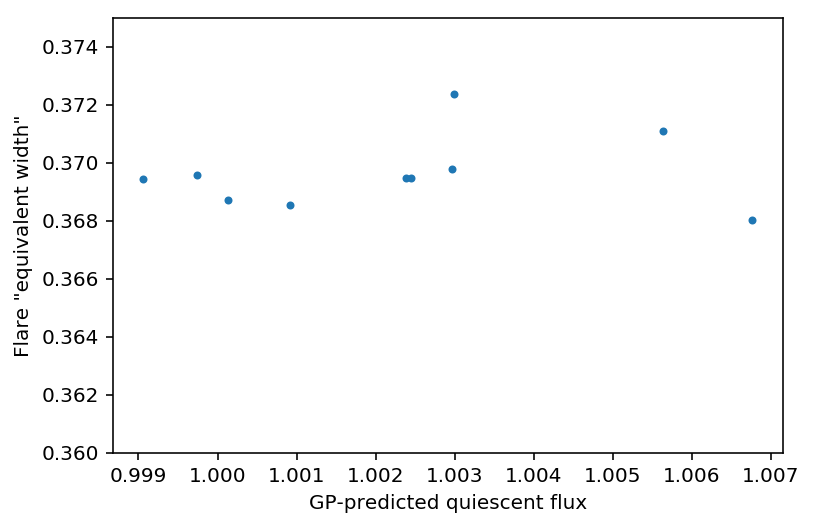

In [116]:
plt.plot(quiescent_gp_fluxes, integrated_fluxes, '.')
plt.ylabel('Flare "equivalent width"')
plt.xlabel('GP-predicted quiescent flux')
plt.ylim([0.36, 0.375])
plt.savefig('fluence.png', bbox_inches='tight', dpi=200)